# SCVI in R with Seurat


In this tutorial, we go over how to use basic scvi-tools functionality in R. However, for more involved analyses, we suggest using scvi-tools from Python. Checkout the [Scanpy_in_R tutorial](https://theislab.github.io/scanpy-in-R/#converting-from-r-to-python-1) for instructions on converting Seurat objects to anndata. 

This tutorial requies Reticulate. Please check out our installation [guide](TODO) for instructions on installing Reticulate and scvi-tools from R.

## Loading and Processing Data with Seurat
We follow the basic Seurat [tutorial](https://satijalab.org/seurat/v3.2/pbmc3k_tutorial.html) for loading data and selecting highly variable genes.

**Note: scvi-tools requires raw gene expression**

In [1]:
# We will work within the Seurat framework
library(Seurat)

pbmc.data <- Read10X(data.dir = "/Users/galen/Downloads/filtered_gene_bc_matrices\ 4/hg19/")
pbmc <- CreateSeuratObject(counts = pbmc.data, project = "pbmc3k", min.cells = 3, min.features = 200)
pbmc[["percent.mt"]] <- PercentageFeatureSet(pbmc, pattern = "^MT-")
pbmc <- subset(pbmc, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)
pbmc <- FindVariableFeatures(pbmc, selection.method = "vst", nfeatures = 2000)
top2000 <- head(VariableFeatures(pbmc), 2000)
pbmc <- pbmc[top2000]

print(pbmc) # Seurat object

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


An object of class Seurat 
2000 features across 2638 samples within 1 assay 
Active assay: RNA (2000 features, 2000 variable features)


## Converting Seurat Object to Anndata

scvi-tools relies on the [AnnData](https://anndata.readthedocs.io/en/latest/) object. Here we show how to convert our Seurat object to anndata for scvi-tools.



In [2]:
library(reticulate)

sc <- import('scanpy', convert = FALSE)
scvi <- import('scvi', convert = FALSE)
scvi.setting.progress_bar_style = 'tqdm'

In [3]:
# convert seurat obj to anndata
adata <- sc$AnnData(
  X   = t(as.matrix(GetAssayData(pbmc))),
  obs = pbmc[[]],
  var = GetAssay(pbmc)[[]]
)
print(adata) # Note generally in Python, dataset conventions are obs x var

AnnData object with n_obs × n_vars = 2638 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'


## Setup our AnnData for Training

Reticulate allows us to call Python code from R, giving the ability to use all of scvi-tools in R. We encourage you to checkout their [documentation](https://rstudio.github.io/reticulate/articles/calling_python.html) and specifically the section on type conversions in order to pass arguments to Python functions.

In this section, we show how to setup the AnnData for scvi-tools, create the model, train the model, and get the latent representation. For a more in depth description of setting up the data, you can checkout our [introductory tutorial](https://www.scvi-tools.org/en/latest/user_guide/notebooks/api_overview.html) as well as our [data loading tutorial](https://www.scvi-tools.org/en/latest/user_guide/notebooks/data_loading.html). 


In [4]:
# run seteup_anndata
scvi$data$setup_anndata(adata)

# create the model
model = scvi$model$SCVI(adata)

# train the model
model$train(n_epochs = as.integer(400))


None

None

## Getting the Latent Represenation and Visualization
Here we get the latent representation of the model and save it back in our Seurat object. Then we run UMAP and visualize. 

In [5]:
# get the latent represenation
latent = model$get_latent_representation()

# put it back in our original Seurat object
latent <- as.matrix(latent)
rownames(latent) = colnames(pbmc)
pbmc[['scvi']] <- CreateDimReducObject(embeddings = latent, key = "scvi_", assay = DefaultAssay(pbmc))


Warning message:
“No columnames present in cell embeddings, setting to 'scvi_1:10'”


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2638
Number of edges: 94031

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7175
Number of communities: 9
Elapsed time: 0 seconds


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
15:54:49 UMAP embedding parameters a = 0.9922 b = 1.112

15:54:49 Read 2638 rows and found 10 numeric columns

15:54:49 Using Annoy for neighbor search, n_neighbors = 30

15:54:49 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

15:54:50 Writing NN index file to temp file /var/folders/08/l7_h9rq54fn8fs8v2p0yd77w0000gn/T//RtmpXZc4U6/file18b76688ff22

15:54:50 Searching Annoy index using 1 thread, search_k = 3000

15:54:51 Annoy recall = 100%

15:54:52 Commencing smooth kNN distance calibra

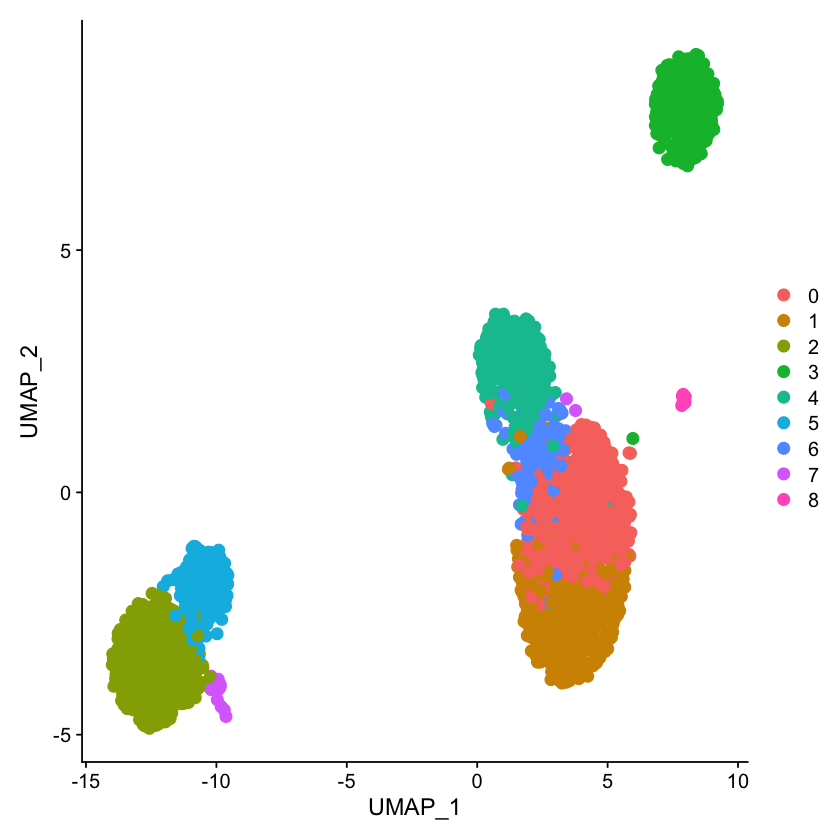

In [6]:
# Find clusters, then run UMAP, and visualize
pbmc <- FindNeighbors(pbmc, dims = 1:10, reduction = 'scvi')
pbmc <- FindClusters(pbmc, resolution =1)

pbmc <- RunUMAP(pbmc, dims = 1:10, reduction = 'scvi', n.components = 2)

DimPlot(pbmc, reduction = "umap", pt.size = 3)


## Finding differentially expressed genes with SCVI latent space

In [7]:
# we need pandas in order to put the seurat clusters into our original anndata
pd <- import('pandas', convert = FALSE)

# workaround for adding seurat_clusters to our anndata
new_obs <- c(adata$obs, pd$DataFrame(pbmc[['seurat_clusters']]))
new_obs <- pd$concat(new_obs, axis =1)

adata$obs <- new_obs


Using our trained SCVI model, we call the `differential_expression()` method
We pass `seurat_clusters` to the groupby argument and compare between cluster `1` and cluster `2`.

The output of DE is a DataFrame with the bayes factors. Bayes factors > 3 have high probability of being differentially expressed. You can also set fdr_target, which will return the differentially expressed genes based on the posteior expected FDR. 

In [10]:
adata

AnnData object with n_obs × n_vars = 2638 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', 'seurat_clusters'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    uns: '_scvi'

In [13]:
DE <- model$differential_expression(adata, groupby='seurat_clusters', group1 = '1', group2 = '2', fdr_target = 0.05)

ERROR: Error in py_call_impl(callable, dots$args, dots$keywords): TypeError: get_bayes_factors() got an unexpected keyword argument 'fdr_target'

Detailed traceback: 
  File "/Users/galen/anaconda3/envs/r/lib/python3.8/site-packages/scvi/core/models/rnamixin.py", line 188, in differential_expression
    result = _de_core(
  File "/Users/galen/anaconda3/envs/r/lib/python3.8/site-packages/scvi/core/models/_utils.py", line 60, in _de_core
    all_info = dc.get_bayes_factors(



In [12]:
DE <- model$differential_expression(adata, groupby='seurat_clusters', group1 = '1', group2 = '2')

In [14]:
print(DE$head())

        proba_de  proba_not_de  bayes_factor    scale1  ...  non_zeros_proportion2  raw_normalized_mean1  raw_normalized_mean2  comparison
TYROBP       1.0           0.0     18.420681  0.000319  ...               0.993392              3.582922            145.540314      1 vs 2
GRN          1.0           0.0     18.420681  0.000108  ...               0.759912              1.474228             22.306147      1 vs 2
S100A9       1.0           0.0     18.420681  0.000352  ...               0.995595              3.601406            400.816162      1 vs 2
LGALS1       1.0           0.0     18.420681  0.000547  ...               0.977974              4.766060            111.042053      1 vs 2
FTL          1.0           0.0     18.420681  0.010518  ...               1.000000            153.459152            972.052063      1 vs 2

[5 rows x 17 columns]


## Integrating Datasets with SCVI

Here we reproduce the results from Seurat's [Integration and Label Transfer Vignette](https://satijalab.org/seurat/v3.2/integration.html).

In [113]:
library('SeuratData')
InstallData("ifnb")
data("ifnb")

# use seurat for variable gene selection 


Registered S3 method overwritten by 'cli':
  method     from    
  print.boxx spatstat



In [189]:
ifnb[["percent.mt"]] <- PercentageFeatureSet(ifnb, pattern = "^MT-")
ifnb <- subset(ifnb, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)
ifnb <- FindVariableFeatures(ifnb, selection.method = "vst", nfeatures = 2000)
top2000 <- head(VariableFeatures(ifnb), 2000)
ifnb <- ifnb[top2000]

In [190]:
adata <- anndata$AnnData(
  X   = t(as.matrix(GetAssayData(ifnb))),
  obs = ifnb[[]]
)

print(adata)

AnnData object with n_obs × n_vars = 13997 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations', 'percent.mt'


In [191]:
# run seteup_anndata, use column stim for batch
scvi$data$setup_anndata(adata, batch_key = 'stim')

# create the model
model = scvi$model$SCVI(adata)

# train the model
model$train(n_epochs = as.integer(400))


None

None

In [192]:
# get the latent represenation
latent = model$get_latent_representation()

# put it back in our original Seurat object
latent <- as.matrix(latent)
rownames(latent) = colnames(ifnb)
ifnb[['scvi']] <- CreateDimReducObject(embeddings = latent, key = "scvi_", assay = DefaultAssay(ifnb))

Warning message:
“No columnames present in cell embeddings, setting to 'scvi_1:10'”


15:15:10 UMAP embedding parameters a = 0.9922 b = 1.112

15:15:10 Read 13997 rows and found 10 numeric columns

15:15:10 Using Annoy for neighbor search, n_neighbors = 30

15:15:10 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

15:15:12 Writing NN index file to temp file /var/folders/08/l7_h9rq54fn8fs8v2p0yd77w0000gn/T//RtmpiFvWwm/filed5486517ed36

15:15:12 Searching Annoy index using 1 thread, search_k = 3000

15:15:17 Annoy recall = 100%

15:15:17 Commencing smooth kNN distance calibration using 1 thread

15:15:18 Initializing from normalized Laplacian + noise

Spectral initialization failed to converge, using random initialization instead

15:15:18 Commencing optimization for 200 epochs, with 518038 positive edges

15:15:25 Optimization finished

Warning message i

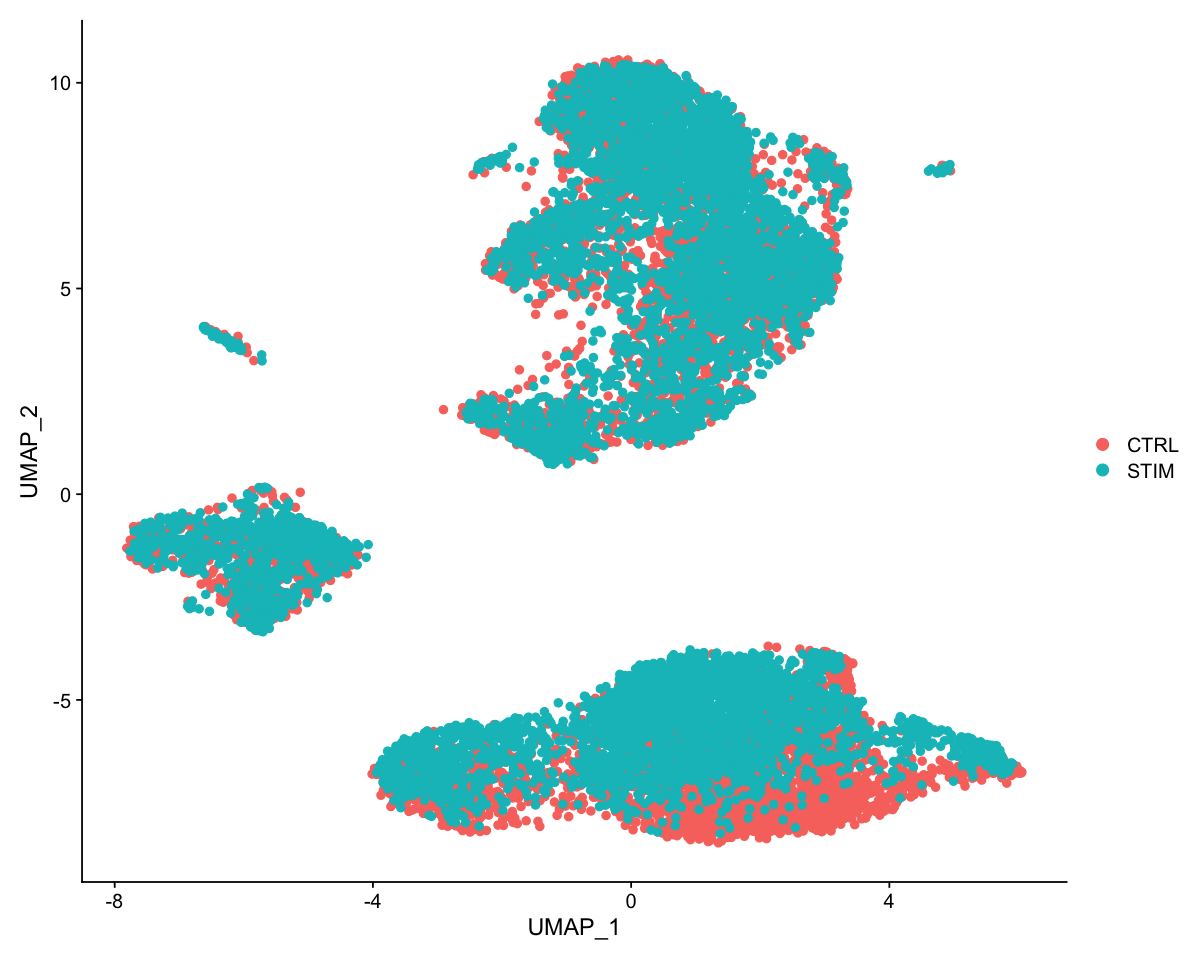

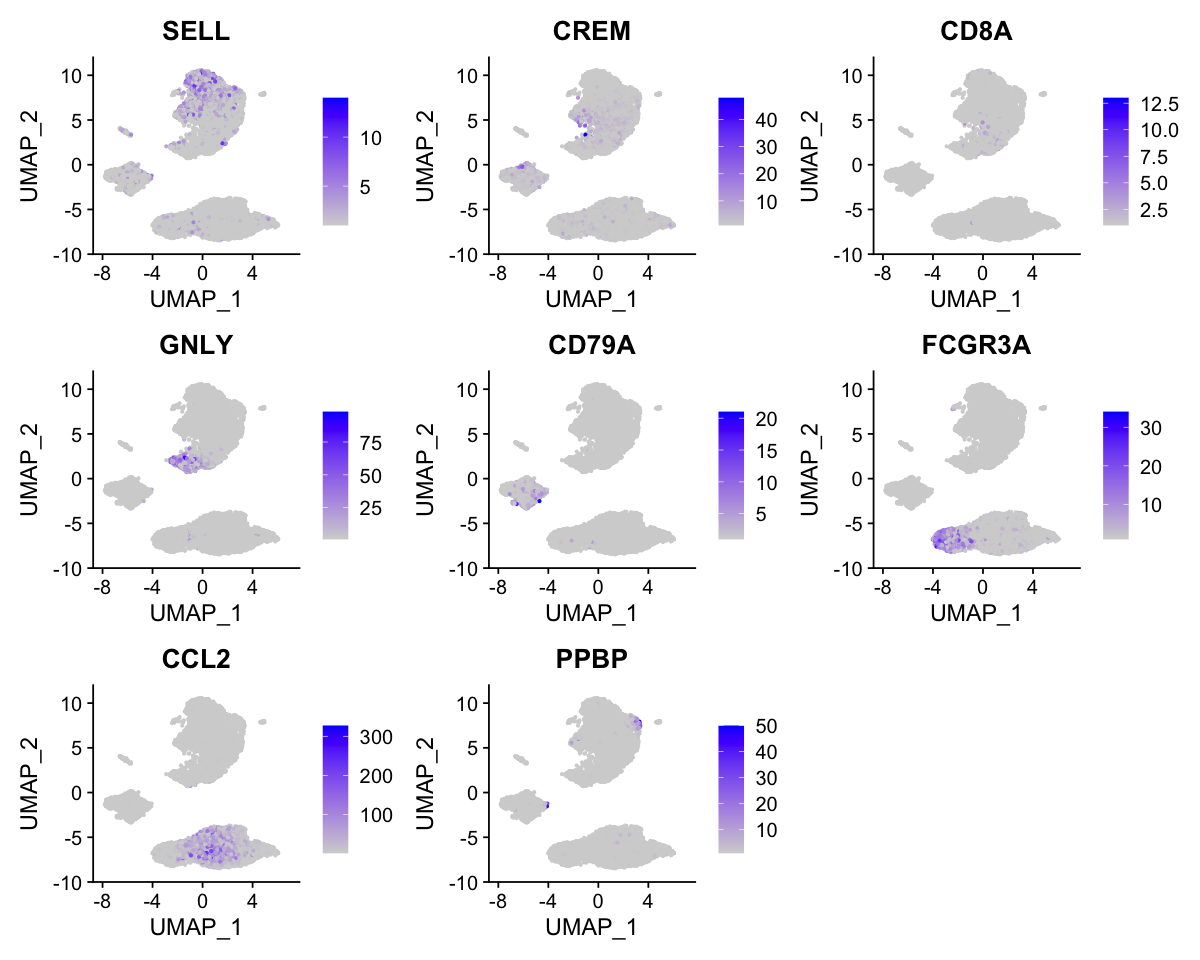

In [194]:
library(cowplot)
# for jupyter notebook
options(repr.plot.width=10, repr.plot.height=8)

ifnb <- RunUMAP(ifnb, dims = 1:10, reduction = 'scvi', n.components = 2)
p1 <- DimPlot(ifnb, reduction = "umap", group.by = "stim", pt.size=2)
plot_grid(p1)

FeaturePlot(ifnb, features = c("CD3D", "SELL", "CREM", "CD8A", "GNLY", "CD79A", "FCGR3A", 
    "CCL2", "PPBP"), min.cutoff = "q9")

In [ ]:
# run this next
# FeaturePlot(immune.combined, features = c("CD3D", "GNLY", "IFI6"), split.by = "stim", max.cutoff = 3, 
#     cols = c("grey", "red"))